In [1]:
topology_file = '../out/sim/20taxa/2seed/tree-sim.newick'
beast_result_file = '../out/sim/20taxa/2seed/10000sites/beast.pickle'
# correlation_plot_out_file = '../out/sim/20taxa/2seed/10000sites/rate-correlations-scaled_conjugate.png'
# marginal_plot_out_file = '../out/sim/20taxa/2seed/10000sites/marginals-scaled_conjugate.png'
# rate_marginal_plot_out_file = '../out/sim/20taxa/2seed/10000sites/rate-marginals-scaled_conjugate.png'
# variational_fit_file = '../out/sim/20taxa/2seed/10000sites/variational-fit-scaled_conjugate.pickle'
# clock_approx = 'scaled_conjugate'
correlation_plot_out_file = '../out/sim/20taxa/2seed/10000sites/rate-correlations-scaled.png'
marginal_plot_out_file = '../out/sim/20taxa/2seed/10000sites/marginals-scaled.png'
rate_marginal_plot_out_file = '../out/sim/20taxa/2seed/10000sites/rate-marginals-scaled.png'
variational_fit_file = '../out/sim/20taxa/2seed/10000sites/variational-fit-scaled.pickle'
clock_approx = 'scaled'
model_file = '../config/model.yaml'

In [2]:
from treeflow_pipeline.util import pickle_input, yaml_input

beast_result = pickle_input(beast_result_file)
variational_fit = pickle_input(variational_fit_file)

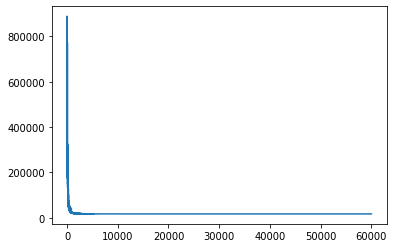

In [3]:
import matplotlib.pyplot as plt
plt.plot(variational_fit['loss'])

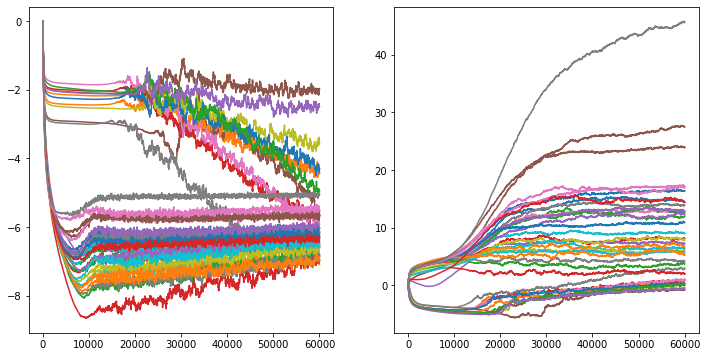

In [4]:
n_branches = beast_result['branch_lengths'].shape[1]
rate_var_traces = [x for x in variational_fit['params'] if x.shape[-1] == n_branches] # TODO: How can we make sure we get the right variables?
fig, axs = plt.subplots(ncols=len(rate_var_traces), figsize=(12, 6))
for ax, rate_var_trace in zip(axs, rate_var_traces):
    ax.plot(rate_var_trace)

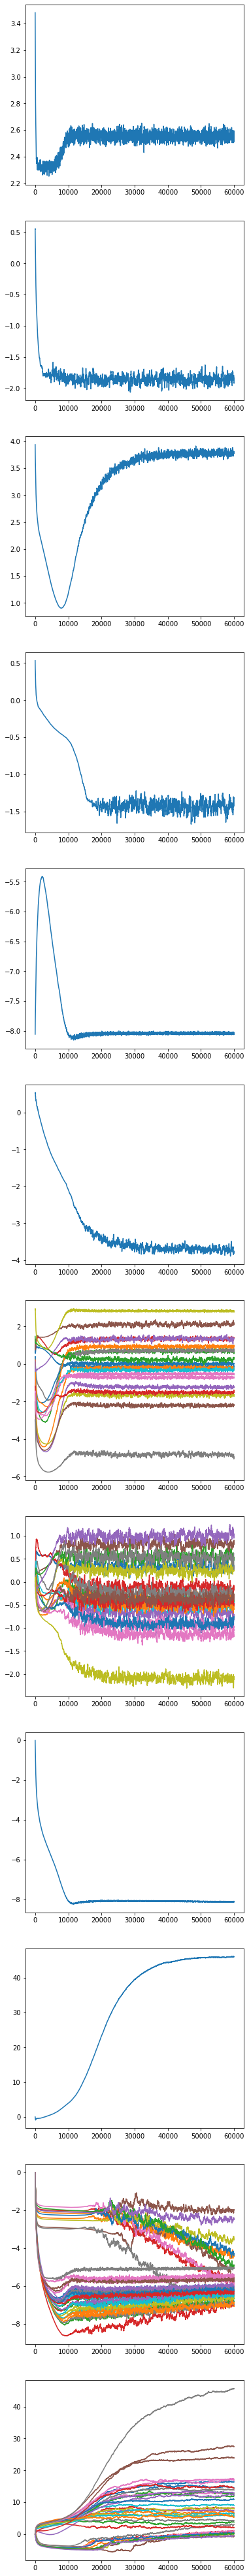

In [5]:
n_params = len(variational_fit['params'])
fig, axs = plt.subplots(nrows=n_params, figsize=(6, 6*n_params))
for ax, trace in zip(axs, variational_fit['params']):
    ax.plot(trace)

## Parameter estimates

In [6]:
import treeflow_pipeline.model

model = treeflow_pipeline.model.Model(yaml_input(model_file))
approx = treeflow_pipeline.model.reconstruct_approx(topology_file, variational_fit, model, clock_approx)

/home/cswa648/dev/treeflow/treeflow/coalescent.py:98: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
Distribution subclass Deterministic inherits `_parameter_properties from its parent (Deterministic)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['loc', 'atol', 'rtol']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    paramet

### Branch rate correlations

Distribution subclass Deterministic inherits `_parameter_properties from its parent (Deterministic)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['loc', 'atol', 'rtol']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_para

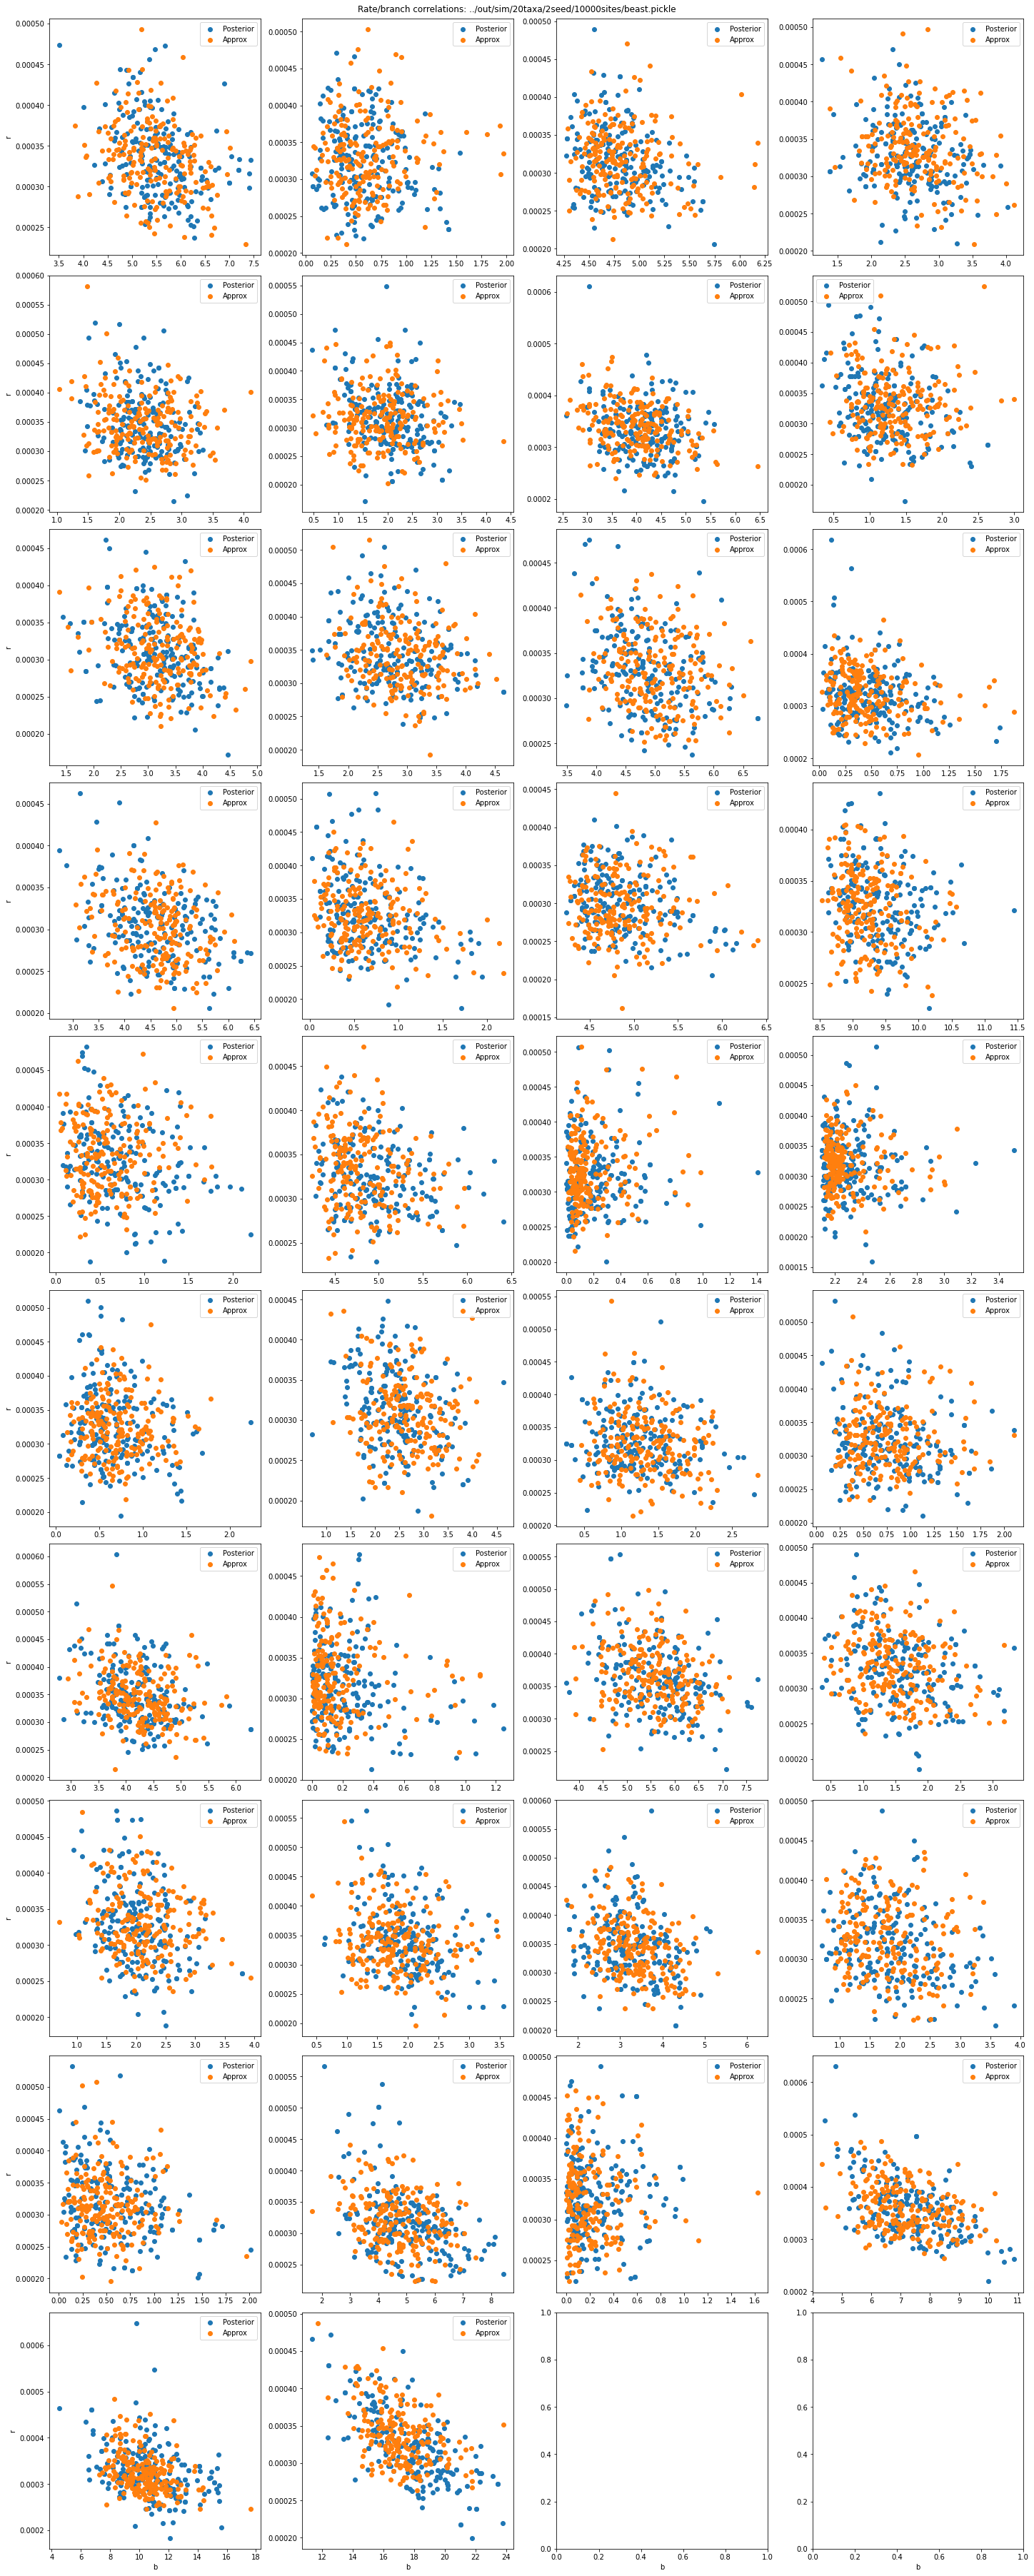

In [7]:
import treeflow.sequences
import numpy as np

n_cols = 4
n_rows = int(np.ceil(n_branches / n_cols))

n_plot_samples = 200
n_beast_samples = beast_result['branch_lengths'].shape[0]
beast_sample_indices = np.random.choice(n_beast_samples, n_plot_samples)

approx_samples = approx.sample(n_plot_samples)
approx_blens = treeflow.sequences.get_branch_lengths(approx_samples['tree'])
approx_rates_t =  approx_samples['rates'].numpy().T
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]
for ax, branch_b, branch_rates, approx_b, approx_rates in zip(axs_flat, beast_result['branch_lengths'][beast_sample_indices].T, beast_result['absolute_rates'][beast_sample_indices].T, approx_blens.numpy().T, approx_rates_t):
    ax.scatter(branch_b, branch_rates, label='Posterior')
    ax.scatter(approx_b, approx_rates, label='Approx')
    leg = ax.legend()

for ax in axs[-1]:
    ax.set_xlabel('b')

for row in axs:
    row[0].set_ylabel('r')

plt.suptitle('Rate/branch correlations: ' + beast_result_file);
plt.savefig(correlation_plot_out_file)

### Parameter correlations

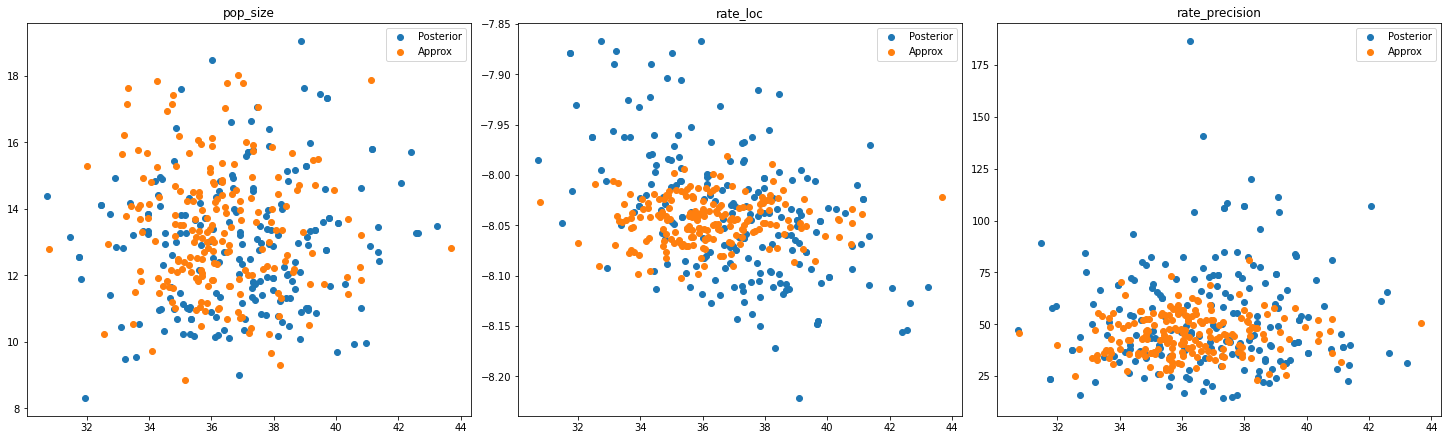

In [8]:
other_vars = model.free_params().keys()
fig, axs = plt.subplots(ncols=len(other_vars), figsize=(20, 6), constrained_layout=True)

beast_root_heights = beast_result['heights'][beast_sample_indices, -1]
approx_root_heights = approx_samples['tree']['heights'][:, -1].numpy()

for var, ax in zip(other_vars, axs):
    ax.set_title(var)
    ax.scatter(beast_root_heights, beast_result[var][beast_sample_indices], label='Posterior')
    ax.scatter(approx_root_heights, approx_samples[var], label='Approx')
    leg = ax.legend()

### Branch rate marginals

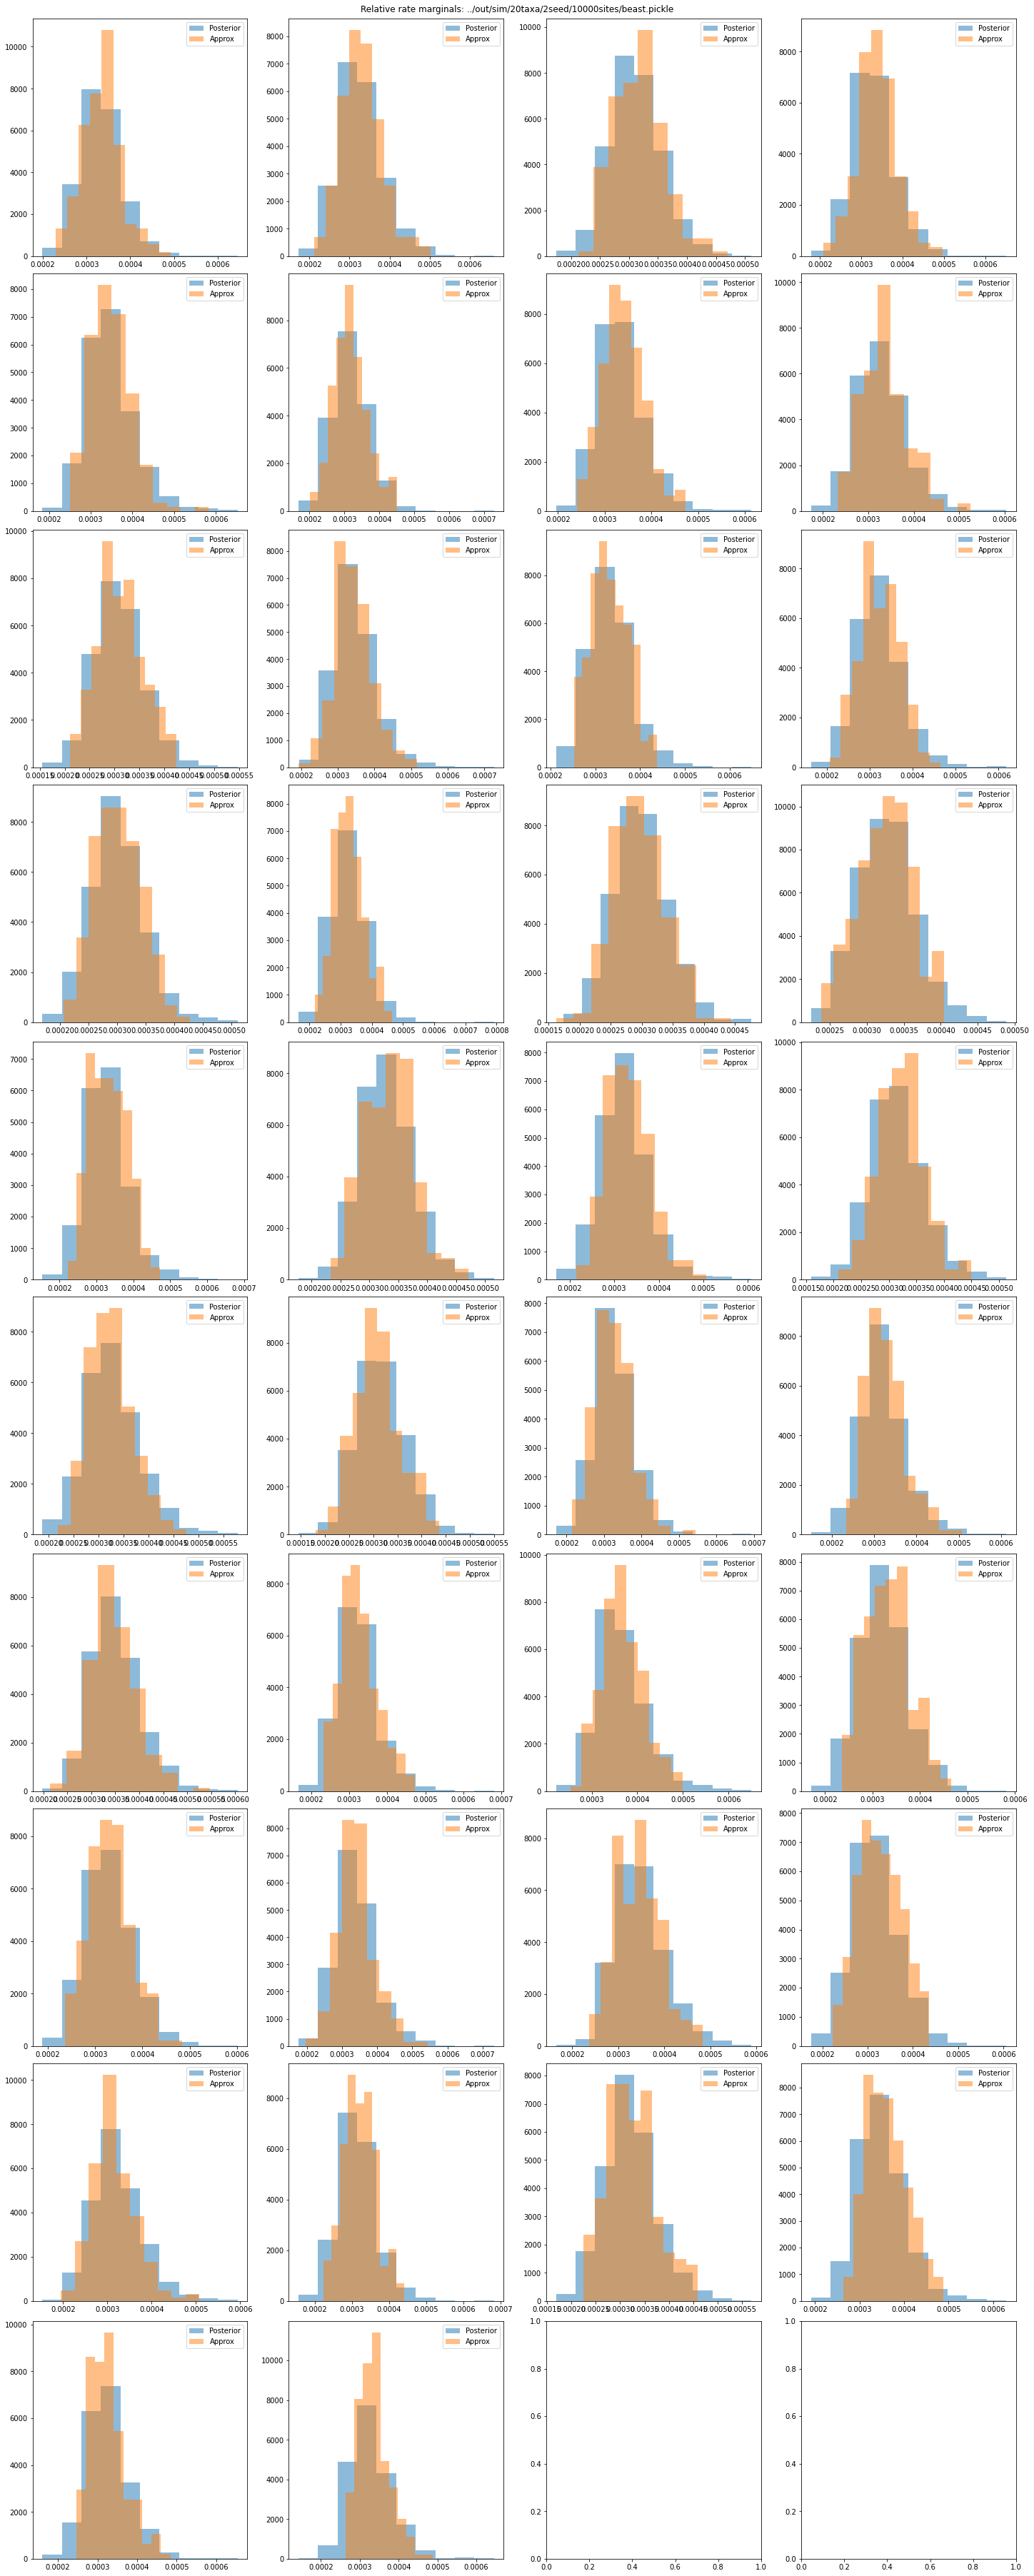

In [9]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

for ax, branch_rates, approx_rates, in zip(axs_flat, beast_result['rates'].T, approx_samples['rates'].numpy().T):
    ax.hist(branch_rates, alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_rates, alpha=0.5, label='Approx', density=True)
    leg = ax.legend()


plt.suptitle('Relative rate marginals: ' + beast_result_file);
plt.savefig(rate_marginal_plot_out_file)

### Node height marginals

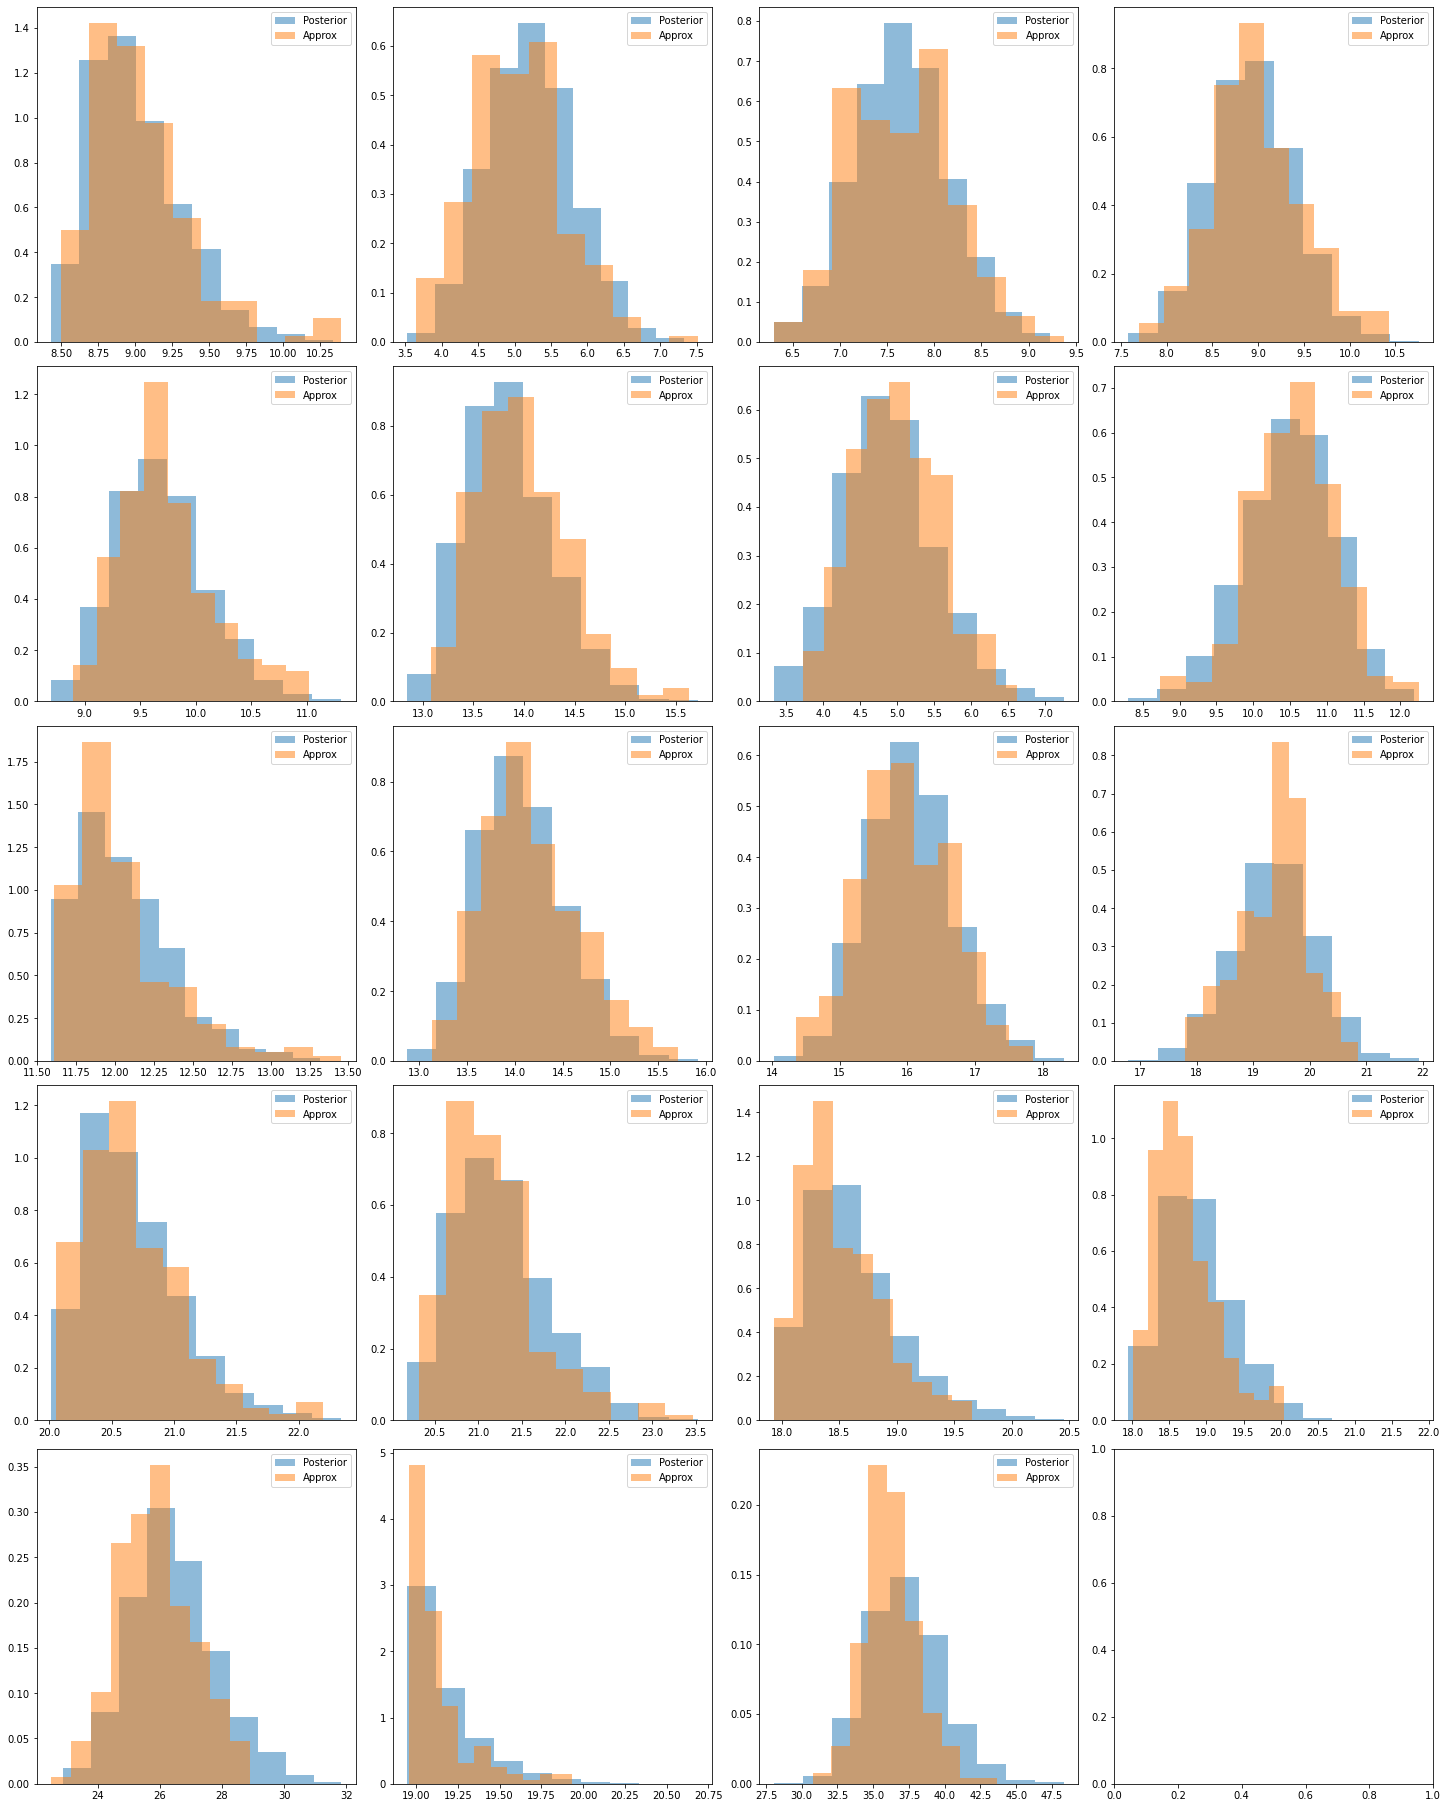

In [10]:
internal_node_count = n_branches // 2
taxon_count = internal_node_count + 1
n_rows = int(np.ceil(internal_node_count / n_cols))

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

for ax, heights, approx_heights, in zip(axs_flat, beast_result['heights'].T[taxon_count:], approx_samples['tree']['heights'].numpy().T[taxon_count:]):
    ax.hist(heights, alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_heights, alpha=0.5, label='Approx', density=True)
    leg = ax.legend()

### Parameter marginals

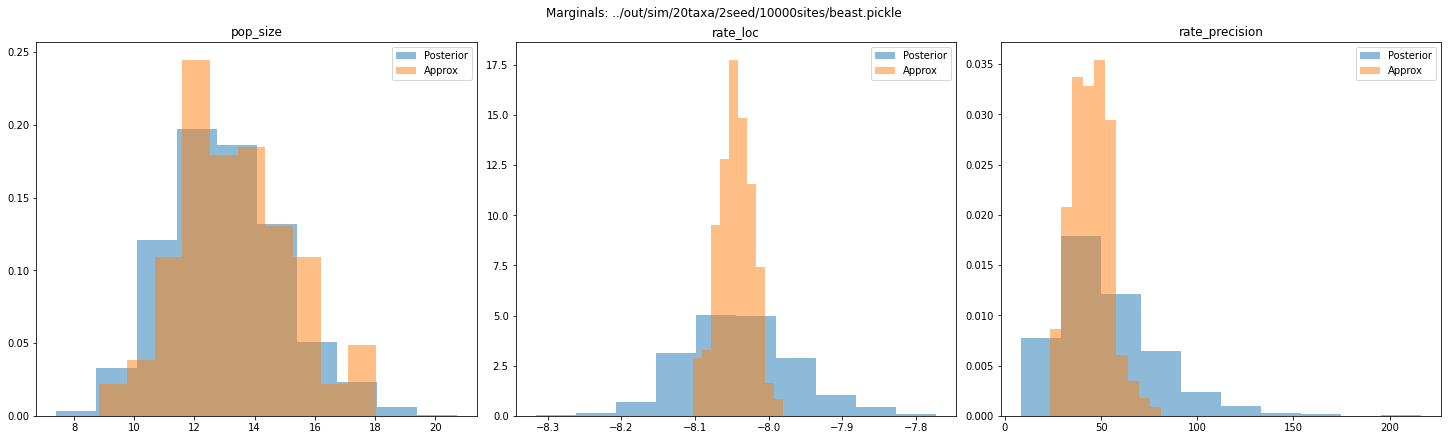

In [11]:
fig, axs = plt.subplots(ncols=len(other_vars), figsize=(20, 6), constrained_layout=True)
for var, ax in zip(other_vars, axs):
    ax.set_title(var)
    ax.hist(beast_result[var], alpha=0.5, label='Posterior', density=True)
    ax.hist(approx_samples[var].numpy(), alpha=0.5, label='Approx', density=True)
    leg = ax.legend()
    
plt.suptitle('Marginals: ' + beast_result_file);
plt.savefig(marginal_plot_out_file)

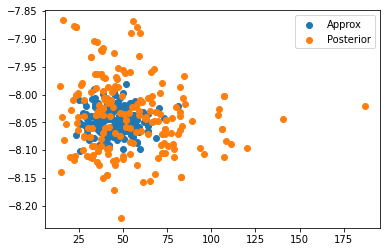

In [24]:
plt.scatter(approx_samples["rate_precision"], approx_samples["rate_loc"], label="Approx")

plt.scatter(beast_result["rate_precision"][beast_sample_indices], beast_result["rate_loc"][beast_sample_indices], label="Posterior")
plt.legend()

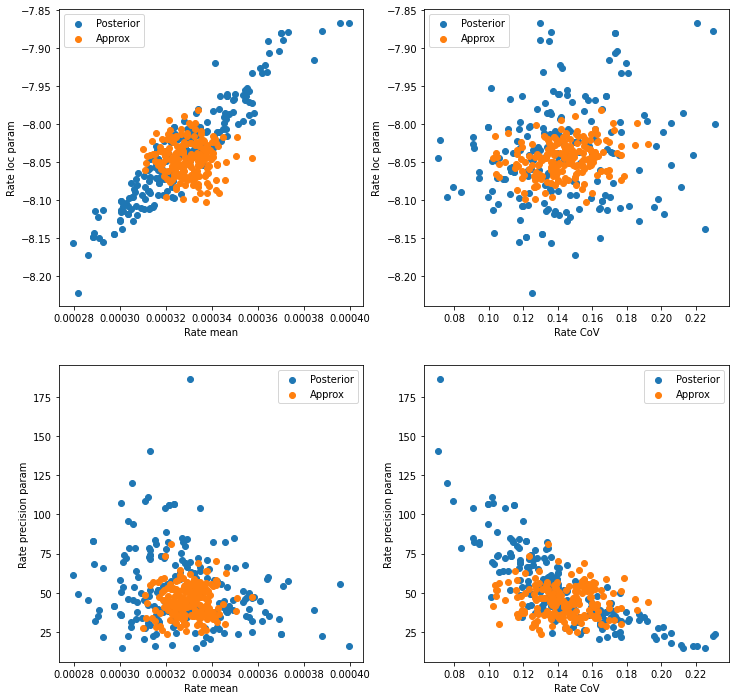

In [25]:
approx_rate_mean = np.mean(approx_samples["rates"], axis=-1)
approx_rate_cov = np.std(approx_samples["rates"], axis=-1) / approx_rate_mean


beast_rate_mean = np.mean(beast_result["rates"], axis=-1)
beast_rate_cov = np.std(beast_result["rates"], axis=-1) / beast_rate_mean

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs[0][0].scatter(beast_rate_mean[beast_sample_indices], beast_result["rate_loc"][beast_sample_indices], label="Posterior")
axs[0][0].scatter(approx_rate_mean, approx_samples["rate_loc"], label="Approx")               
axs[0][0].set_xlabel("Rate mean")
axs[0][0].set_ylabel("Rate loc param")
axs[0][0].legend()

axs[0][1].scatter(beast_rate_cov[beast_sample_indices], beast_result["rate_loc"][beast_sample_indices], label="Posterior")
axs[0][1].scatter(approx_rate_cov, approx_samples["rate_loc"], label="Approx")               
axs[0][1].set_xlabel("Rate CoV")
axs[0][1].set_ylabel("Rate loc param")
axs[0][1].legend()

axs[1][0].scatter(beast_rate_mean[beast_sample_indices], beast_result["rate_precision"][beast_sample_indices], label="Posterior")
axs[1][0].scatter(approx_rate_mean, approx_samples["rate_precision"], label="Approx")               
axs[1][0].set_xlabel("Rate mean")
axs[1][0].set_ylabel("Rate precision param")
axs[1][0].legend()
              
axs[1][1].scatter(beast_rate_cov[beast_sample_indices], beast_result["rate_precision"][beast_sample_indices], label="Posterior")
axs[1][1].scatter(approx_rate_cov, approx_samples["rate_precision"], label="Approx") 
axs[1][1].set_xlabel("Rate CoV")
axs[1][1].set_ylabel("Rate precision param")
axs[1][1].legend()

In [14]:
beast_means = { key: value.mean(axis=0) for key, value in beast_result.items() }
beast_means

{'pop_size': 13.01265462329086,
 'rate_loc': -8.039645942254232,
 'rate_precision': 52.984978824396336,
 'branch_lengths': array([ 5.50625021,  0.58576574,  4.79629206,  2.60907009,  2.39771854,
         2.06119468,  4.16645784,  1.21704246,  3.12006385,  2.77939542,
         4.88465858,  0.47799927,  4.6310619 ,  0.67172959,  4.88225591,
         9.41053112,  0.72667124,  4.93719755,  0.23338119,  2.33864435,
         0.6834211 ,  2.44178702,  1.26398313,  0.76537991,  4.15838193,
         0.22858896,  5.60382632,  1.56846174,  2.02026372,  1.95535563,
         3.33533801,  1.89288375,  0.58905816,  5.20049586,  0.26280725,
         7.57706828, 10.74450621, 18.02504021]),
 'heights': array([10.52631579,  8.42105263,  4.21052632,  6.31578947,  5.26315789,
         3.15789474,  1.05263158, 12.63157895,  7.36842105,  2.10526316,
         0.        , 11.57894737, 14.73684211, 20.        , 15.78947368,
         9.47368421, 17.89473684, 13.68421053, 18.94736842, 16.84210526,
         9.0068

In [15]:
# tree, taxon_names = treeflow.tree_processing.parse_newick(topology_file)
# taxon_count = len(taxon_names)
# sampling_times = tree["heights"][:taxon_count]
# test_point = dict(
#     tree=tree,
#     rates=beast_means["rates"],
#     pop_size=beast_means["pop_size"]
# )
# # calculation_points = dict(
# #     rate_loc=np.concatenate([beast_result["rate_loc"][::100],approx_samples["rate_loc"].numpy()]),
# #     rate_precision=np.concatenate([beast_result["rate_precision"][::100],approx_samples["rate_precision"].numpy()]),
# #     **test_point
# # )
# calculation_points_approx = dict(
#      rate_loc=approx_samples["rate_loc"].numpy(),
#      rate_precision=approx_samples["rate_precision"].numpy(),
#      **test_point
#  )
# calculation_points_beast = dict(
#      rate_loc=beast_result["rate_loc"][::18],
#      rate_precision=beast_result["rate_precision"][::18],
#      **test_point
#  )
# approx_log_probs_approx = approx.log_prob(calculation_points_approx)
# approx_log_probs_beast = approx.log_prob(calculation_points_beast)
# prior = treeflow_pipeline.model.get_phylo_prior(sampling_times, model)
# prior_log_probs_approx = prior.log_prob(calculation_points_approx)
# prior_log_probs_beast = prior.log_prob(calculation_points_beast)

In [16]:
# plt.scatter(calculation_points_approx["rate_loc"], prior_log_probs_approx, label="Prior (approx samples)")
# plt.scatter(calculation_points_beast["rate_loc"], prior_log_probs_beast, label="Prior (Beast samples)")
# plt.scatter(calculation_points_approx["rate_loc"], approx_log_probs_approx, label="Approx (approx samples)")
# plt.scatter(calculation_points_beast["rate_loc"], approx_log_probs_beast, label="Approx (beast samples)")
# plt.legend()

In [17]:
# plt.scatter(calculation_points_approx["rate_precision"], prior_log_probs_approx, label="Prior (approx samples)")
# plt.scatter(calculation_points_beast["rate_precision"], prior_log_probs_beast, label="Prior (Beast samples)")
# plt.scatter(calculation_points_approx["rate_precision"], approx_log_probs_approx, label="Approx (approx samples)")
# plt.scatter(calculation_points_beast["rate_precision"], approx_log_probs_beast, label="Approx (beast samples)")
# plt.legend()

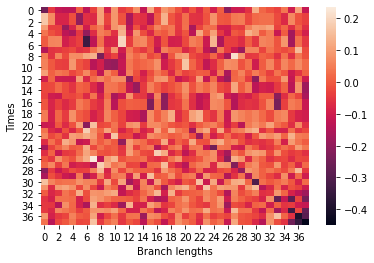

In [18]:
import seaborn as sns
import numpy as np

approx_corr = np.corrcoef(approx_samples["rates"], approx_blens, rowvar=False)[n_branches:, :n_branches]
ax = sns.heatmap(approx_corr)
ax.set(xlabel="Branch lengths", ylabel="Times");

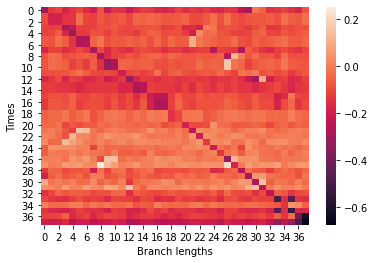

In [19]:
true_corr = np.corrcoef(beast_result["rates"], beast_result["branch_lengths"], rowvar=False)[n_branches:, :n_branches]
ax = sns.heatmap(true_corr)
ax.set(xlabel="Branch lengths", ylabel="Times");

In [20]:
# Reverse transform posterior into my parameterisation

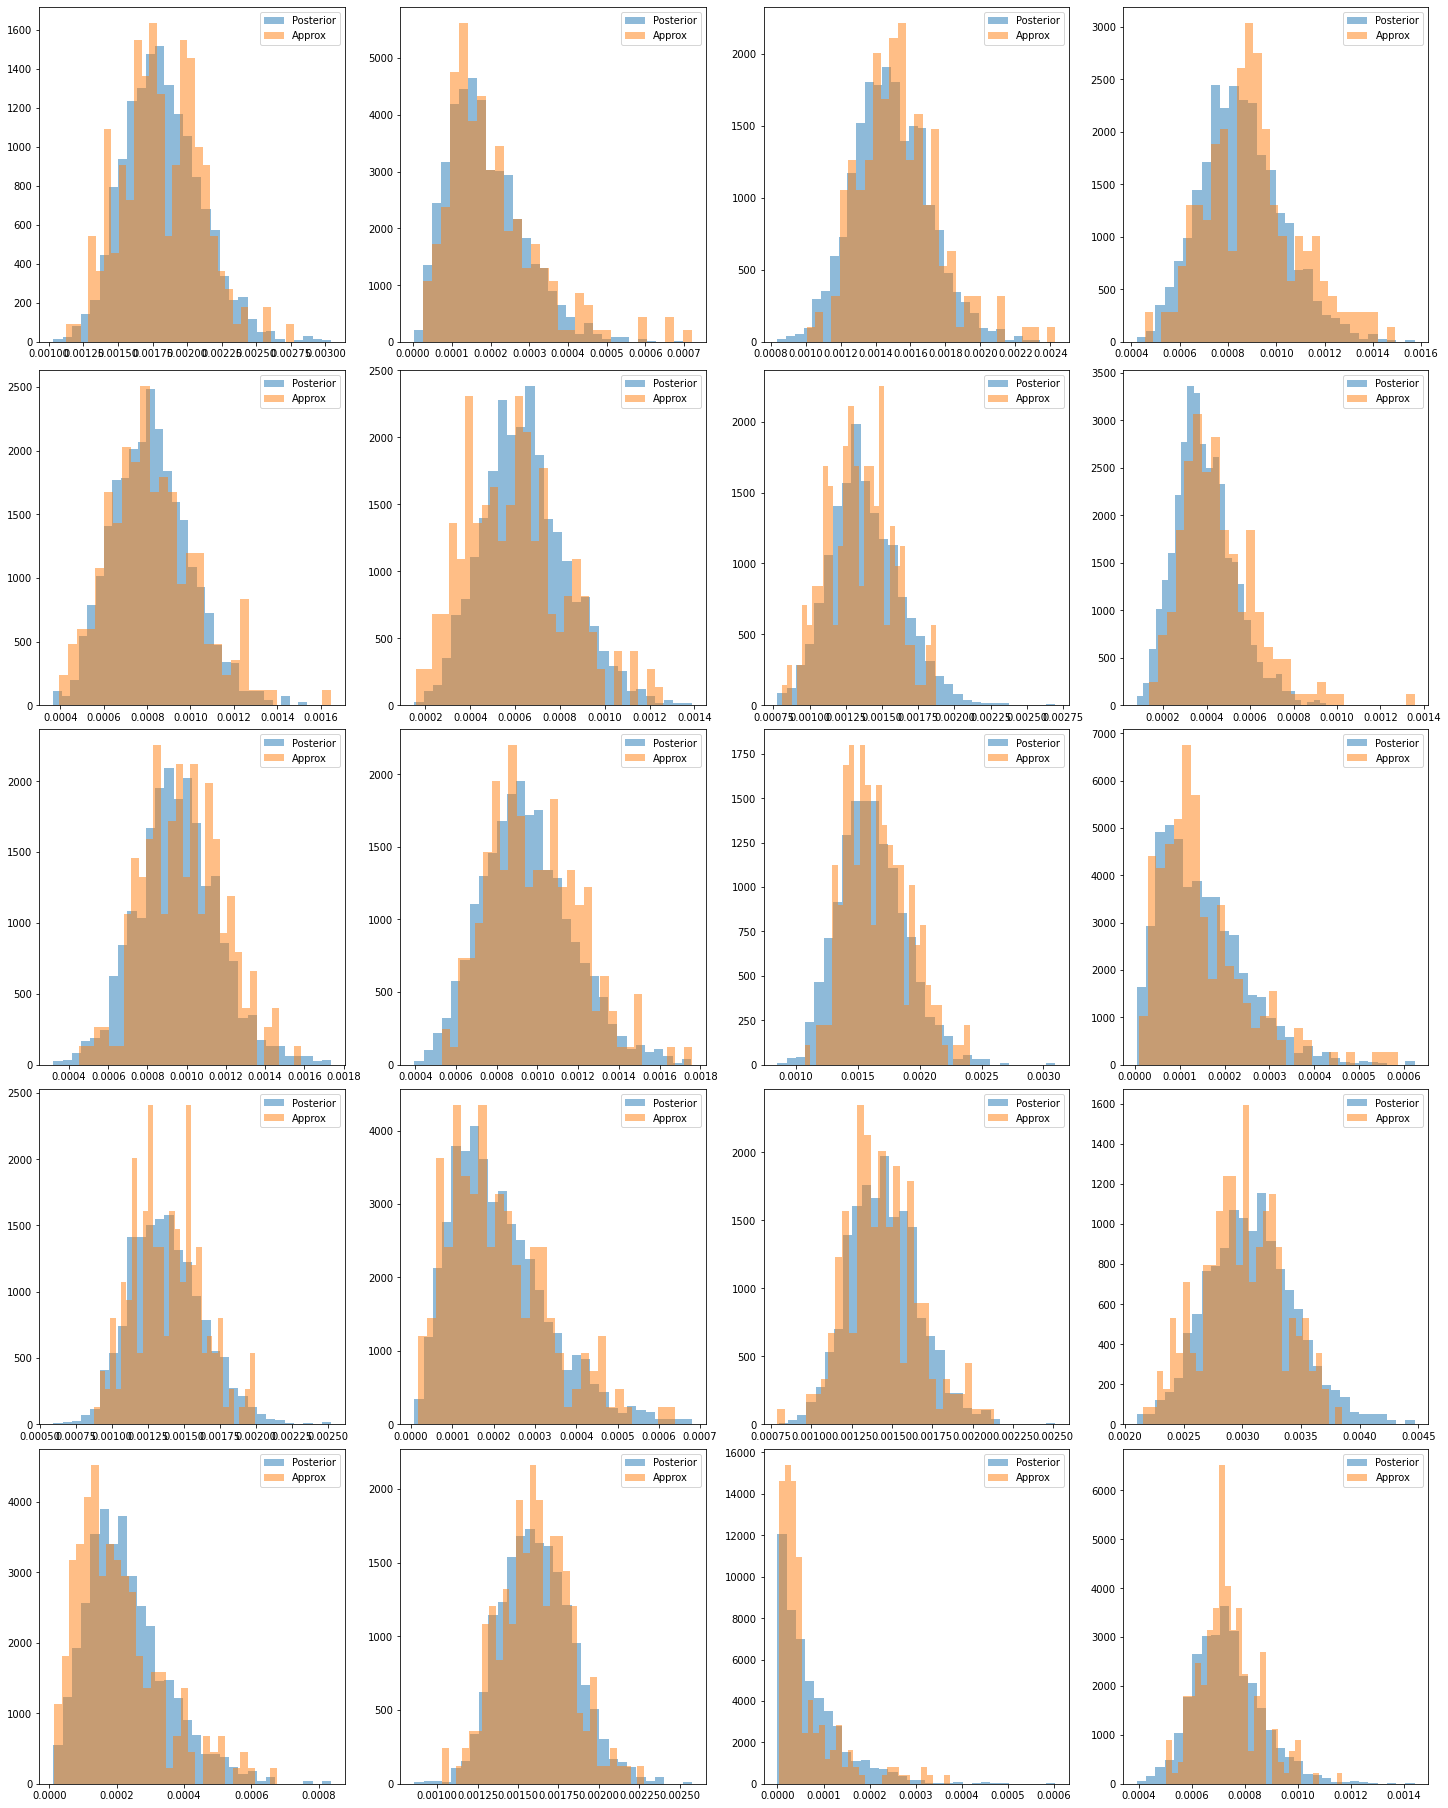

In [21]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

true_distances = beast_result["rates"] * beast_result["branch_lengths"]
approx_distances = (approx_blens * approx_samples["rates"]).numpy()

for ax, ds, approx_ds, in zip(axs_flat, true_distances.T, approx_distances.T):
    ax.hist(ds, alpha=0.5, label='Posterior', density=True, bins=30)
    ax.hist(approx_ds, alpha=0.5, label='Approx', density=True, bins=30)
    leg = ax.legend()

/home/cswa648/miniconda3/envs/libsbn/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()
/home/cswa648/miniconda3/envs/libsbn/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()
/home/cswa648/miniconda3/envs/libsbn/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where 

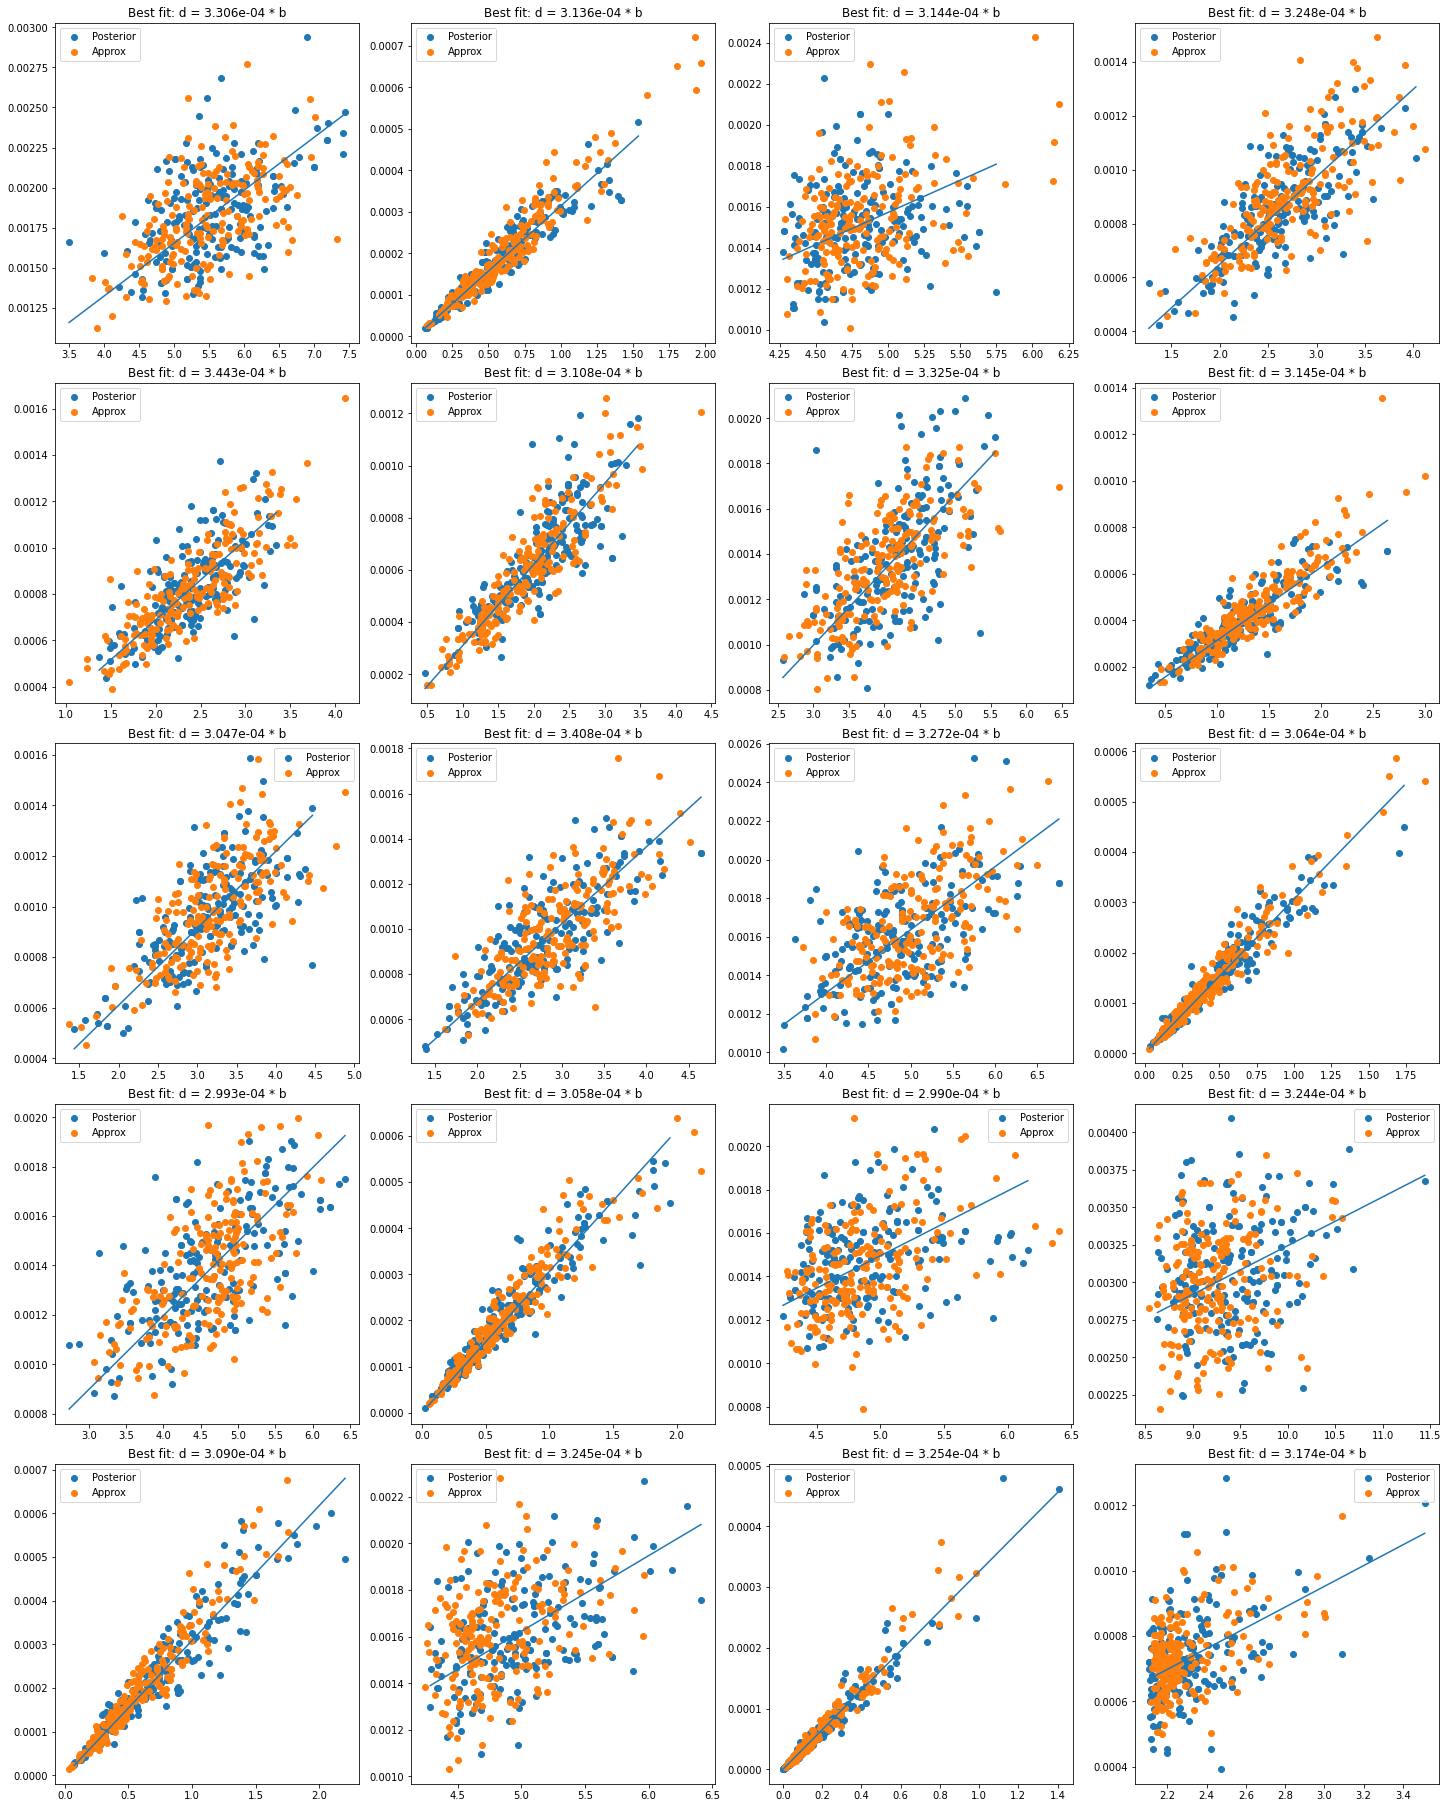

In [22]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

true_distances = (beast_result["rates"] * beast_result["branch_lengths"])[beast_sample_indices]
approx_distances = (approx_blens * approx_samples["rates"]).numpy()

for ax, bs, ds, approx_ds, approx_bs in zip(
        axs_flat,
        beast_result["branch_lengths"][beast_sample_indices].T,
        true_distances.T,
        approx_distances.T,
        approx_blens.numpy().T
):
    ax.scatter(bs, ds, label='Posterior')
    #m, c = np.polyfit(bs, ds, 1)
    m, _, _, _ = np.linalg.lstsq(bs[:, np.newaxis], ds)
    b_space = np.linspace(min(bs), max(bs))
    ax.plot(b_space, b_space * m)
    ax.set_title("Best fit: d = {m:.3e} * b".format(m=m[0]))
    
    
    ax.scatter(approx_bs, approx_ds, label='Approx')
    leg = ax.legend()

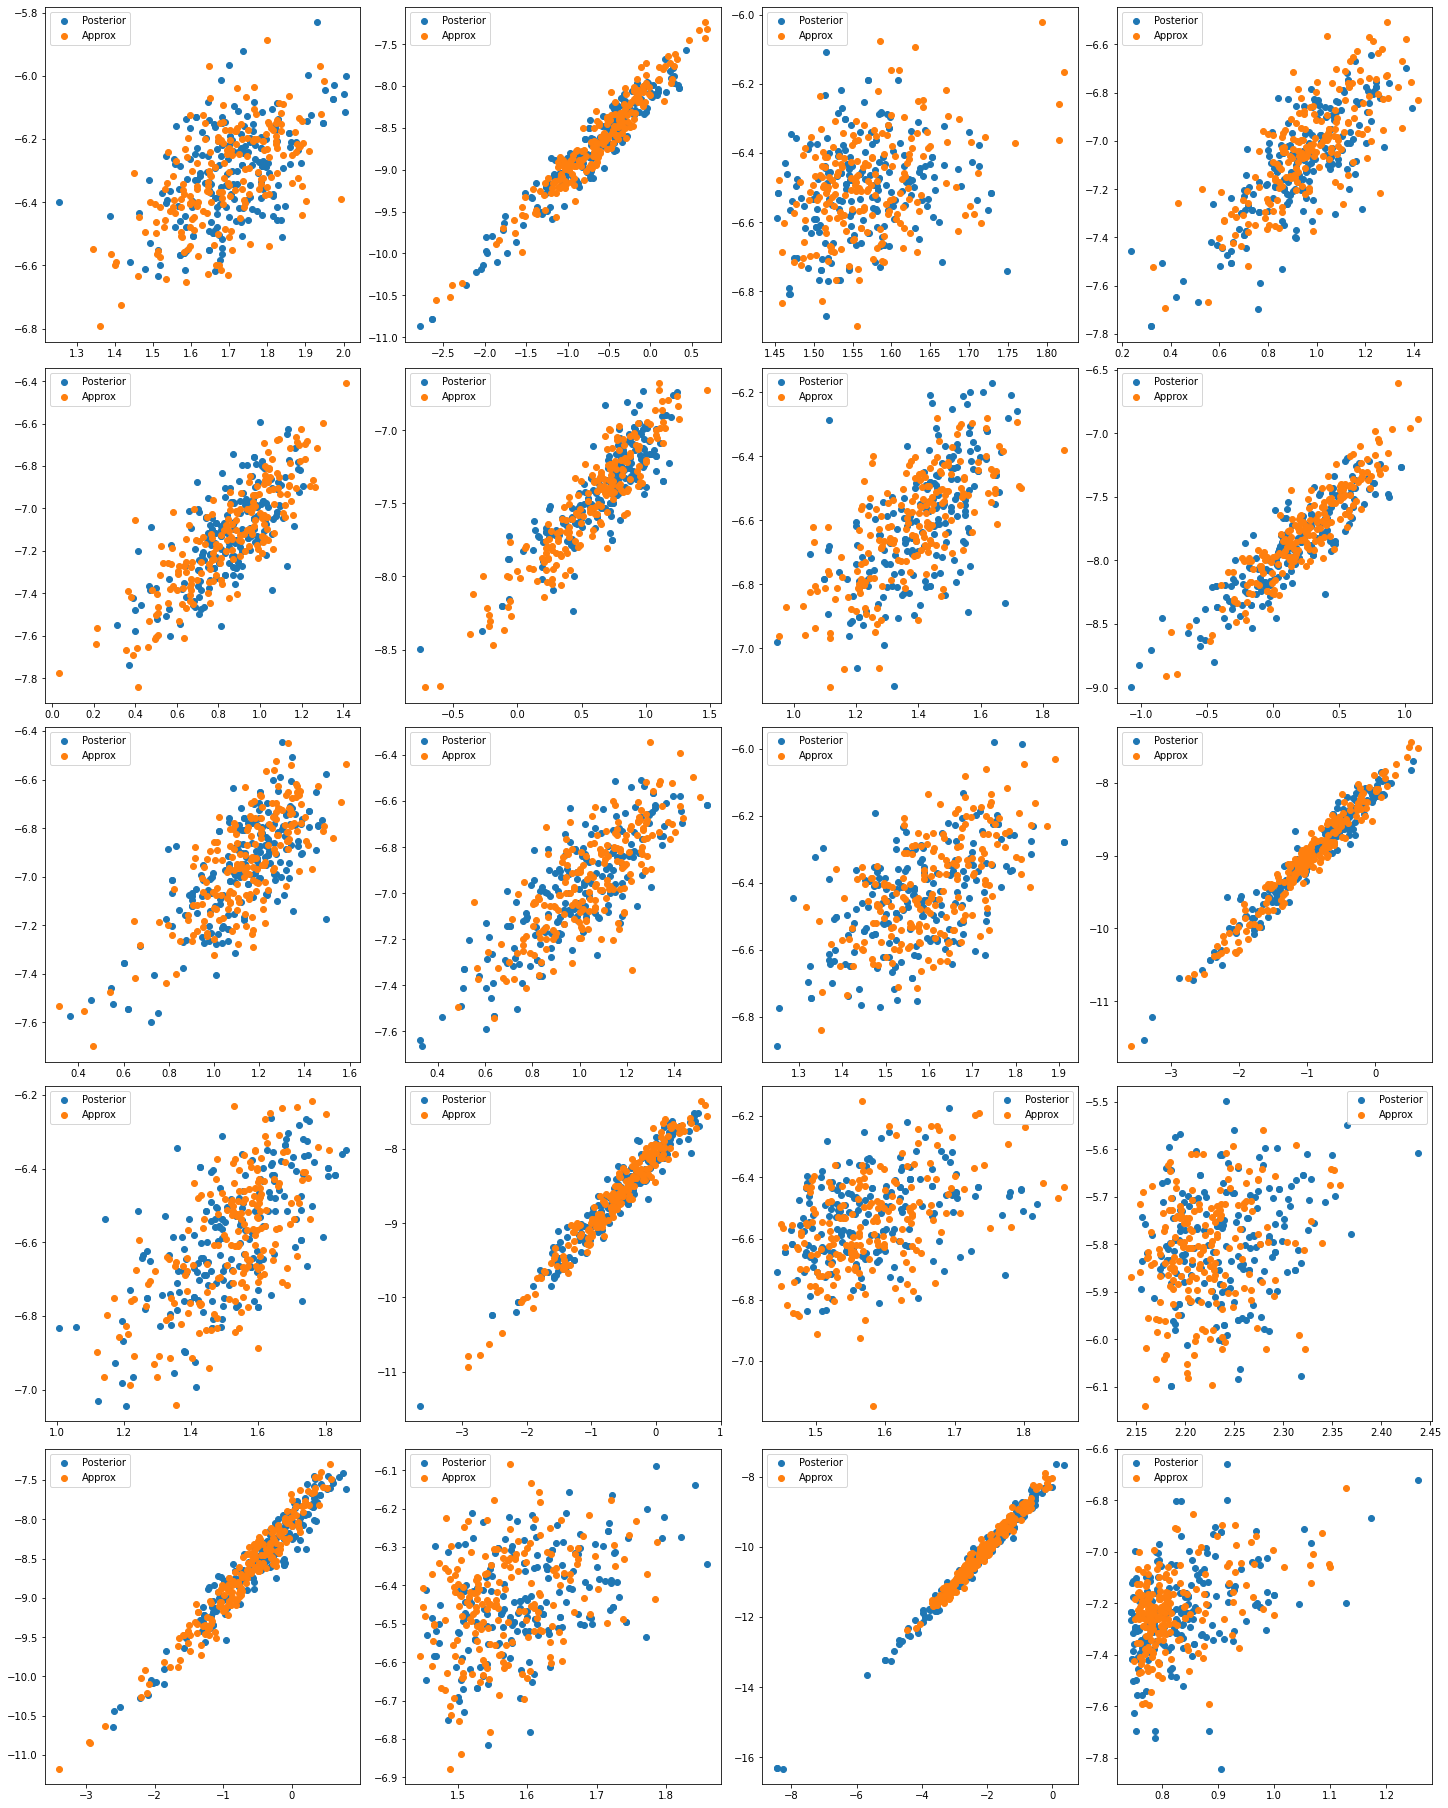

In [23]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]

for ax, bs, ds, approx_ds, approx_bs in zip(
        axs_flat,
        beast_result["branch_lengths"][beast_sample_indices].T,
        true_distances.T,
        approx_distances.T,
        approx_blens.numpy().T
):
    ax.scatter(np.log(bs), np.log(ds), label='Posterior')
    ax.scatter(np.log(approx_bs), np.log(approx_ds), label='Approx')
    leg = ax.legend()